In [39]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint 
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

In [40]:
# data downloading and reading
"""
XLK ETF top 25 components:
NVDA
AAPL
MSFT
AVGO
PLTR
AMD
CSCO
ORCL
IBM
MU
CRM
AMAT
LRCX
QCOM
INTU
APH
NOW
INTC
APP
ACN
KLAC
TXN
ADBE
ANET
ADI

"""
# Symbols from XLK ETF components
symbol_list = ['NVDA', 'AAPL', 'MSFT', 'AVGO', 'PLTR', 'AMD', 'CSCO', 'ORCL', 'IBM', 'MU',
               'CRM', 'AMAT', 'LRCX', 'QCOM', 'INTU', 'APH', 'NOW', 'INTC', 'APP', 'ACN',
               'KLAC', 'TXN', 'ADBE', 'ANET', 'ADI']

# # set the dates range
# start_date = '2020-01-01'
# end_date = dt.datetime.now().strftime('%Y-%m-%d')

# # download data
# # data = yf.download(symbol_list, period="max", group_by='ticker', auto_adjust=True)
# data = yf.download(symbol_list, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# # download data to csv
# data.to_csv(f"{'_'.join(symbol_list)}_D_data.csv")

# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv(f"{'_'.join(symbol_list)}_D_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

data = df.copy()

# Show the result
data.head()

Ticker            AMD                                              PLTR       \
Price            Open       High        Low      Close      Volume Open High   
Date                                                                           
2020-01-02  46.860001  49.250000  46.630001  49.099998  80331100.0  NaN  NaN   
2020-01-03  48.029999  49.389999  47.540001  48.599998  73127400.0  NaN  NaN   
2020-01-06  48.020000  48.860001  47.860001  48.389999  47934900.0  NaN  NaN   
2020-01-07  49.349998  49.389999  48.040001  48.250000  58061400.0  NaN  NaN   
2020-01-08  47.849998  48.299999  47.139999  47.830002  53767000.0  NaN  NaN   

Ticker                       ...         ADI                          \
Price      Low Close Volume  ...        Open        High         Low   
Date                         ...                                       
2020-01-02 NaN   NaN    NaN  ...  108.222748  108.709306  106.988334   
2020-01-03 NaN   NaN    NaN  ...  106.321559  107.826277  106.078284   
2020-01-06 NaN   NaN    NaN  ...  104.744754  105.708856  104.168095   
2020-01-07 NaN   NaN    NaN  ...  107.132493  108.916529  106.681978   
2020-01-08 NaN   NaN    NaN  ...  108.402934  109.439120  107.844300   

Ticker                                  QCOM                                   \
Price            Close     Volume       Open       High        Low      Close   
Date                                                                            
2020-01-02  108.511078  1279300.0  78.359905  79.028666  77.506349  78.043121   
2020-01-03  106.600876  1374400.0  76.784802  77.119182  76.063240  76.573608   
2020-01-06  105.348442  1979400.0  75.596869  76.160039  75.271283  76.124840   
2020-01-07  107.745193  2214700.0  76.591201  78.747086  76.476809  78.289513   
2020-01-08  108.718300  2036500.0  78.227908  78.729482  77.365550  78.060715   

Ticker                 
Price          Volume  
Date                   
2020-01-02  8413900.0  
2020-01-03  8340300.0  
2020-01-06  8381400.0  
2020-01-07  8377400.0  
2020-01-08  7619900.0  

[5 rows x 125 columns]

In [41]:
# Remove rows where all values are NaN
data = data.dropna(how='all')

# For pairs trading, we typically only need Close prices
# Extract Close prices for both tickers
close_prices = data.xs('Close', level=1, axis=1)

# Clean ticker names if needed (remove any suffixes)
close_prices.columns = close_prices.columns.str.replace('=X', '', regex=False)

# Drop any remaining NaN values
close_prices = close_prices.dropna()

print("Cleaned close prices data:")
print(close_prices.head())
print(f"\nData shape: {close_prices.shape}")
print(f"Date range: {close_prices.index.min()} to {close_prices.index.max()}")

# Use close_prices for the pairs trading analysis
data = close_prices

Cleaned close prices data:
Ticker            AMD       PLTR         ACN        APP         CRM  \
Date                                                                  
2021-04-15  83.010002  23.150000  267.145966  65.199997  230.574539   
2021-04-16  82.150002  22.469999  268.841736  61.000000  229.495926   
2021-04-19  81.110001  21.940001  268.448212  58.860001  228.100586   
2021-04-20  79.269997  21.780001  270.378174  60.150002  225.587021   
2021-04-21  81.610001  22.629999  272.364288  61.810001  228.159943   

Ticker             NOW         MU       LRCX        APH        ADBE  ...  \
Date                                                                 ...   
2021-04-15  559.349976  88.111725  61.751179  32.852886  523.250000  ...   
2021-04-16  556.909973  88.492409  61.200695  32.833702  525.080017  ...   
2021-04-19  549.369995  86.296211  59.110950  32.368633  516.169983  ...   
2021-04-20  540.780029  85.388451  58.283802  32.023418  514.210022  ...   
2021-04-21  546.469

In [42]:
# # manual filter to keep Date >= '2014-01-01'
# data = data[data.index >= '2014-01-01']

# # manual filter to exclude Date >= '2024-01-01'
# data = data[data.index < '2024-01-01']

In [43]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [44]:
# Time Series Split for Pairs Trading
# For financial time series, we use temporal split instead of random split
# This preserves the time order and avoids look-ahead bias
def temporal_split(data, train_ratio=0.7):
    """
    Split time series data temporally (chronologically)
    
    Parameters:
    data: DataFrame with time series data
    train_ratio: proportion of data to use for training (default 70%)
    
    Returns:
    train_data: DataFrame with training period data
    test_data: DataFrame with testing period data
    split_date: the date where split occurs
    """
    n_train = int(len(data) * train_ratio)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]
    split_date = data.index[n_train-1] if n_train > 0 else data.index[0]
    
    print(f"Total observations: {len(data)}")
    print(f"Training period: {data.index[0]} to {split_date} ({len(train_data)} observations)")
    print(f"Testing period: {data.index[n_train]} to {data.index[-1]} ({len(test_data)} observations)")
    print(f"Train ratio: {len(train_data)/len(data):.1%}")
    
    return train_data, test_data, split_date

# Split the forex data temporally
train_data, test_data, split_date = temporal_split(data, train_ratio=0.7)

Total observations: 1163
Training period: 2021-04-15 to 2024-07-10 (814 observations)
Testing period: 2024-07-11 to 2025-11-28 (349 observations)
Train ratio: 70.0%


In [45]:
# Step 1: Find cointegrated pairs using TRAINING data only
# This prevents look-ahead bias in the strategy
scores_train, pvalues_train, pairs_train = find_cointegrated_pairs(train_data)

print("=== TRAINING PERIOD COINTEGRATION ANALYSIS ===")
print(f"Analysis period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Number of observations: {len(train_data)}")

=== TRAINING PERIOD COINTEGRATION ANALYSIS ===
Analysis period: 2021-04-15 to 2024-07-10
Number of observations: 814


In [46]:
# Step 2: Validate cointegration on TEST data
# Check if pairs found in training period maintain cointegration in test period
scores_test, pvalues_test, pairs_test = find_cointegrated_pairs(test_data)

print("\n=== TESTING PERIOD COINTEGRATION VALIDATION ===")
print(f"Analysis period: {test_data.index[0]} to {test_data.index[-1]}")
print(f"Number of observations: {len(test_data)}")

# Function to validate pairs consistency
def validate_pairs_consistency(pairs_train, pairs_test, pvalues_train, pvalues_test, data_train, data_test):
    """
    Validate if pairs found in training maintain cointegration in testing
    """
    print(f"\nPairs found in training: {len(pairs_train)}")
    print(f"Pairs found in testing: {len(pairs_test)}")
    
    # Handle case when no training pairs exist
    if len(pairs_train) == 0:
        print("No pairs found in training period - cannot validate consistency")
        print("Consider:")
        print("- Relaxing cointegration threshold (e.g., p < 0.1)")
        print("- Using longer training period")
        print("- Checking data quality")
        
        # Show best pairs from training period anyway
        if len(pvalues_train) > 0:
            symbols = list(data_train.columns)
            n = len(symbols)
            
            best_train_pairs = []
            for i in range(n):
                for j in range(i+1, n):
                    best_train_pairs.append({
                        'pair': f"{symbols[i]}/{symbols[j]}",
                        'train_pvalue': pvalues_train[i, j],
                        'significant': pvalues_train[i, j] < 0.05
                    })
            
            best_train_df = pd.DataFrame(best_train_pairs)
            best_train_df = best_train_df.sort_values('train_pvalue')
            
            print(f"\nBest pairs from training (sorted by p-value):")
            print(best_train_df.head(5))
        
        return [], pd.DataFrame()
    
    # Check which training pairs are also significant in testing
    consistent_pairs = []
    validation_results = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        
        # Find indices for this pair in training data
        train_cols = list(data_train.columns)
        i_train = train_cols.index(symbol1)
        j_train = train_cols.index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i_train > j_train:
            i_train, j_train = j_train, i_train
        
        train_pvalue = pvalues_train[i_train, j_train]
        
        # Find indices for this pair in testing data  
        test_cols = list(data_test.columns)
        i_test = test_cols.index(symbol1)
        j_test = test_cols.index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i_test > j_test:
            i_test, j_test = j_test, i_test
        
        test_pvalue = pvalues_test[i_test, j_test]
        
        # Check if still cointegrated in test period
        is_consistent = test_pvalue < 0.05
        
        validation_results.append({
            'pair': f"{symbol1}/{symbol2}",
            'train_pvalue': train_pvalue,
            'test_pvalue': test_pvalue,
            'consistent': is_consistent,
            'pvalue_change': test_pvalue - train_pvalue
        })
        
        if is_consistent:
            consistent_pairs.append(pair)
    
    # Create validation DataFrame
    validation_df = pd.DataFrame(validation_results)
    if len(validation_df) > 0:
        validation_df = validation_df.sort_values('test_pvalue')
    
    print(f"Consistent pairs (significant in both periods): {len(consistent_pairs)}")
    if len(pairs_train) > 0:
        print(f"Consistency rate: {len(consistent_pairs)/len(pairs_train):.1%}")
    
    return consistent_pairs, validation_df

# Validate pairs consistency
consistent_pairs, validation_df = validate_pairs_consistency(
    pairs_train, pairs_test, pvalues_train, pvalues_test, train_data, test_data
)

if len(validation_df) > 0:
    print(f"\n=== PAIRS VALIDATION RESULTS ===")
    print(validation_df)
else:
    print(f"\n=== NO VALIDATION POSSIBLE ===")
    print("No cointegrated pairs found in training period")


=== TESTING PERIOD COINTEGRATION VALIDATION ===
Analysis period: 2024-07-11 to 2025-11-28
Number of observations: 349

Pairs found in training: 11
Pairs found in testing: 2
Consistent pairs (significant in both periods): 0
Consistency rate: 0.0%

=== PAIRS VALIDATION RESULTS ===
         pair  train_pvalue  test_pvalue  consistent  pvalue_change
6    ORCL/ADI      0.008754     0.142686       False       0.133932
8   KLAC/AVGO      0.001585     0.208338       False       0.206753
5    TXN/AMAT      0.038289     0.236330       False       0.198042
4    TXN/NVDA      0.030064     0.251517       False       0.221454
2    NOW/INTU      0.004893     0.423597       False       0.418704
7   KLAC/NVDA      0.017119     0.719955       False       0.702836
1    AMD/MSFT      0.048576     0.726174       False       0.677598
9   KLAC/ANET      0.040010     0.760005       False       0.719996
0     AMD/NOW      0.006652     0.914229       False       0.907578
10  AVGO/ANET      0.005859     0.97111

In [47]:
# Alternative Analysis with Relaxed Threshold (p < 0.1)
print("\n" + "="*50)
print("ALTERNATIVE ANALYSIS WITH RELAXED THRESHOLD")
print("="*50)

def find_cointegrated_pairs_relaxed(data, threshold=0.1):
    """
    Same as find_cointegrated_pairs but with adjustable threshold
    """
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < threshold:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

# Try with p < 0.1 threshold
scores_train_relaxed, pvalues_train_relaxed, pairs_train_relaxed = find_cointegrated_pairs_relaxed(train_data, 0.1)
scores_test_relaxed, pvalues_test_relaxed, pairs_test_relaxed = find_cointegrated_pairs_relaxed(test_data, 0.1)

print(f"Training pairs (p < 0.1): {len(pairs_train_relaxed)}")
print(f"Testing pairs (p < 0.1): {len(pairs_test_relaxed)}")

# Show training pairs
if len(pairs_train_relaxed) > 0:
    pairs_train_relaxed_df = pd.DataFrame(pairs_train_relaxed, columns=['Symbol 1', 'Symbol 2'])
    
    pair_pvalues_train_relaxed = []
    for pair in pairs_train_relaxed:
        symbol1, symbol2 = pair
        i = list(train_data.columns).index(symbol1)
        j = list(train_data.columns).index(symbol2)
        pair_pvalues_train_relaxed.append(pvalues_train_relaxed[i, j])
    
    pairs_train_relaxed_df['Training P-Value'] = pair_pvalues_train_relaxed
    pairs_train_relaxed_df.sort_values(by='Training P-Value', inplace=True)
    
    print(f"\nTraining pairs with relaxed threshold:")
    print(pairs_train_relaxed_df)

# Show testing pairs
if len(pairs_test_relaxed) > 0:
    pairs_test_relaxed_df = pd.DataFrame(pairs_test_relaxed, columns=['Symbol 1', 'Symbol 2'])
    
    pair_pvalues_test_relaxed = []
    for pair in pairs_test_relaxed:
        symbol1, symbol2 = pair
        i = list(test_data.columns).index(symbol1)
        j = list(test_data.columns).index(symbol2)
        pair_pvalues_test_relaxed.append(pvalues_test_relaxed[i, j])
    
    pairs_test_relaxed_df['Testing P-Value'] = pair_pvalues_test_relaxed
    pairs_test_relaxed_df.sort_values(by='Testing P-Value', inplace=True)
    
    print(f"\nTesting pairs with relaxed threshold:")
    print(pairs_test_relaxed_df)
else:
    print(f"\nNo pairs found in testing period with p < 0.1")

if len(pairs_train_relaxed) > 0:
    # Validate with relaxed threshold
    consistent_pairs_relaxed, validation_df_relaxed = validate_pairs_consistency(
        pairs_train_relaxed, pairs_test_relaxed, pvalues_train_relaxed, pvalues_test_relaxed, 
        train_data, test_data
    )
    
    if len(consistent_pairs_relaxed) > 0:
        print(f"\nConsistent pairs with relaxed threshold:")
        print(validation_df_relaxed[validation_df_relaxed['consistent']].head())
        
        # Use the best consistent pair for backtesting
        best_pair_relaxed = consistent_pairs_relaxed[0]
        print(f"\nUsing {best_pair_relaxed[0]}/{best_pair_relaxed[1]} for backtesting")
        
        # Store for later use
        pairs_for_backtest = consistent_pairs_relaxed
        best_pair = best_pair_relaxed
    else:
        print("\nNo consistent pairs even with relaxed threshold")
        # Use best training pair anyway for demonstration
        best_pair = pairs_train_relaxed[0]
        pairs_for_backtest = []
        print(f"Using best training pair for demonstration: {best_pair[0]}/{best_pair[1]}")
else:
    print("No pairs found even with relaxed threshold")
    pairs_for_backtest = []


ALTERNATIVE ANALYSIS WITH RELAXED THRESHOLD
Training pairs (p < 0.1): 25
Testing pairs (p < 0.1): 7

Training pairs with relaxed threshold:
   Symbol 1 Symbol 2  Training P-Value
22     KLAC     AVGO          0.001585
5       NOW     INTU          0.004893
24     AVGO     ANET          0.005859
0       AMD      NOW          0.006652
20     ORCL      ADI          0.008754
21     KLAC     NVDA          0.017119
14      TXN     NVDA          0.030064
16      TXN     AMAT          0.038289
23     KLAC     ANET          0.040010
9      LRCX     MSFT          0.047751
2       AMD     MSFT          0.048576
19      TXN     QCOM          0.054526
1       AMD     INTU          0.055069
11      APH     NVDA          0.056912
10      APH     KLAC          0.069403
12      TXN     ORCL          0.072920
3       ACN     INTC          0.075121
4       CRM     INTU          0.076694
8      LRCX     NVDA          0.081422
6        MU     AMAT          0.082032
13      TXN     KLAC          0.083034
1

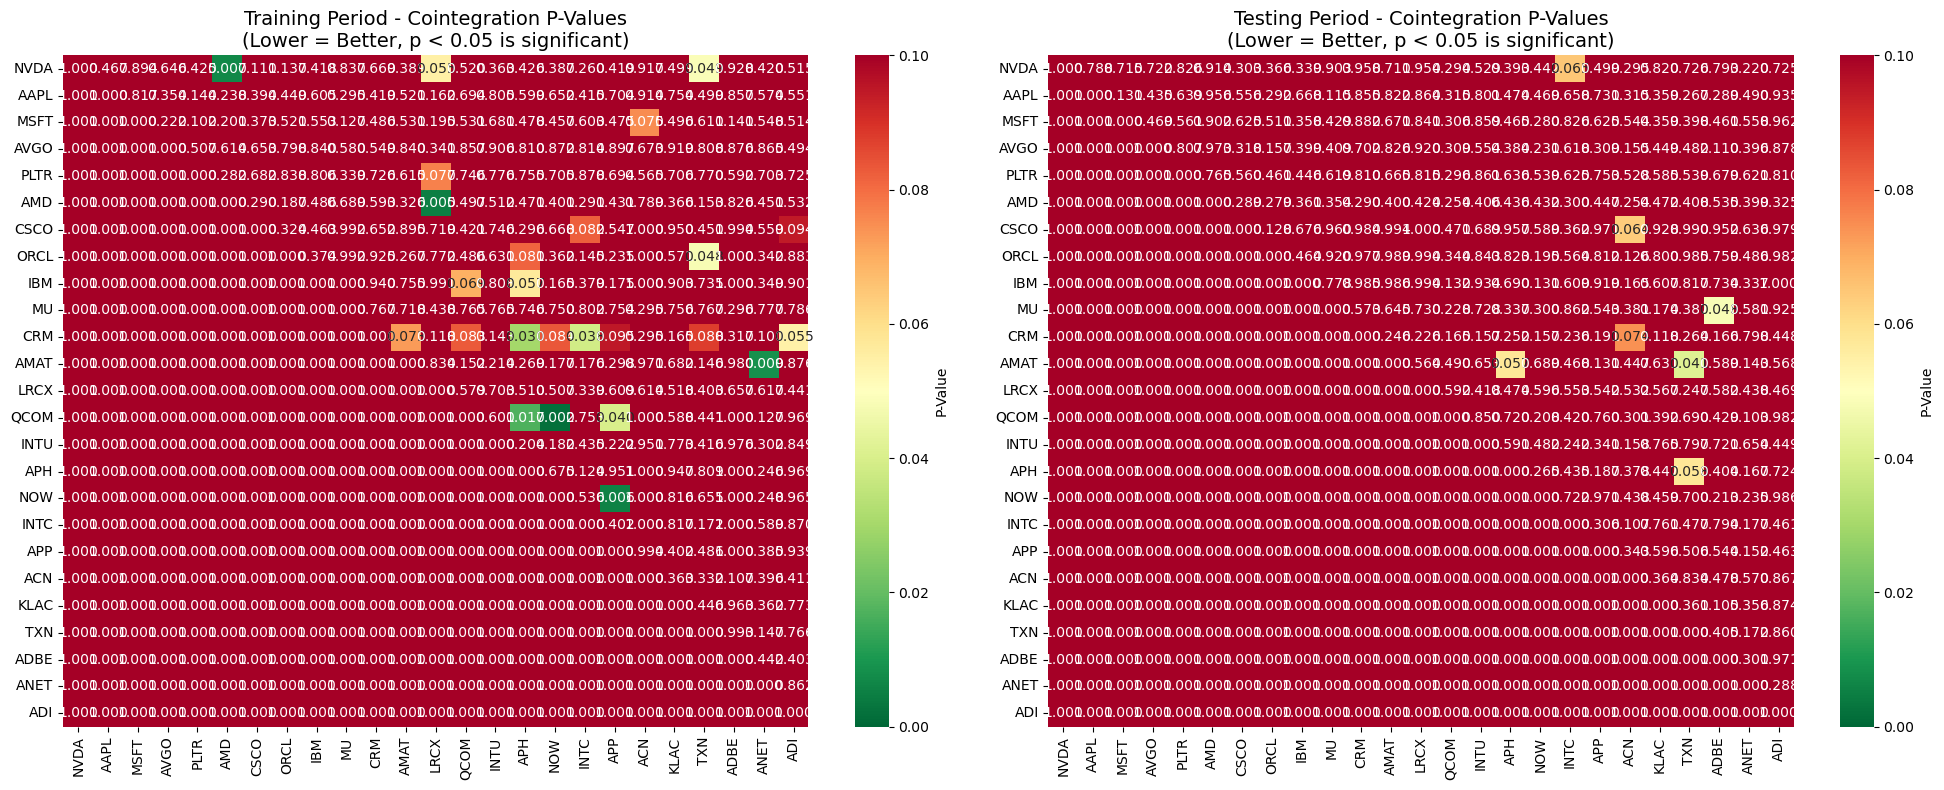

In [48]:
# Visualize cointegration results - Training vs Testing period
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Training period heatmap
sns.heatmap(
    pvalues_train, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r',  # Red = high p-value (bad), Green = low p-value (good)
    vmin=0, 
    vmax=0.1,  # Focus on the significant range
    ax=axes[0],
    annot=True,
    fmt='.3f',
    cbar_kws={'label': 'P-Value'}
)
axes[0].set_title('Training Period - Cointegration P-Values\n(Lower = Better, p < 0.05 is significant)', fontsize=14)

# Testing period heatmap
sns.heatmap(
    pvalues_test, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r',
    vmin=0, 
    vmax=0.1,
    ax=axes[1],
    annot=True,
    fmt='.3f',
    cbar_kws={'label': 'P-Value'}
)
axes[1].set_title('Testing Period - Cointegration P-Values\n(Lower = Better, p < 0.05 is significant)', fontsize=14)

plt.tight_layout()
plt.show()

In [49]:
def print_best_pair_summary(best_pair, pvalues_train, pvalues_test, train_data, test_data):
    """
    Print a summary of the best pair selected for backtesting.
    
    Parameters:
    best_pair: tuple of (symbol1, symbol2)
    pvalues_train: p-value matrix from training period
    pvalues_test: p-value matrix from testing period
    train_data: training DataFrame
    test_data: testing DataFrame
    """
    symbol1, symbol2 = best_pair
    
    # Get p-values for the pair
    cols = list(train_data.columns)
    i = cols.index(symbol1)
    j = cols.index(symbol2)
    
    # Ensure we access the upper triangular part (i < j)
    if i > j:
        i, j = j, i
    
    train_pvalue = pvalues_train[i, j]
    test_pvalue = pvalues_test[i, j]
    
    # Determine consistency
    is_consistent = train_pvalue < 0.1 and test_pvalue < 0.1
    
    print("=" * 50)
    print("BEST PAIR SUMMARY")
    print("=" * 50)
    print(f"Pair: {symbol1} / {symbol2}")
    print("-" * 50)
    print(f"Training P-Value:  {train_pvalue:.4f} {'✅' if train_pvalue < 0.05 else '⚠️' if train_pvalue < 0.1 else '❌'}")
    print(f"Testing P-Value:   {test_pvalue:.4f} {'✅' if test_pvalue < 0.05 else '⚠️' if test_pvalue < 0.1 else '❌'}")
    print("-" * 50)
    print(f"Consistent: {'Yes ✅' if is_consistent else 'No ❌'}")
    print("=" * 50)
    
    return {
        'pair': best_pair,
        'train_pvalue': train_pvalue,
        'test_pvalue': test_pvalue,
        'consistent': is_consistent
    }

# Print the best pair summary
if 'best_pair' in locals():
    best_pair_info = print_best_pair_summary(
        best_pair, 
        pvalues_train_relaxed, 
        pvalues_test_relaxed, 
        train_data, 
        test_data
    )
else:
    print("No best_pair defined. Run the cointegration analysis first.")

BEST PAIR SUMMARY
Pair: AMD / NOW
--------------------------------------------------
Training P-Value:  0.0067 ✅
Testing P-Value:   0.9142 ❌
--------------------------------------------------
Consistent: No ❌


In [50]:
# Display training pairs and validation results
print("=== TRAINING PERIOD COINTEGRATED PAIRS ===")
if len(pairs_train) > 0:
    pairs_train_df = pd.DataFrame(pairs_train, columns=['Symbol 1', 'Symbol 2'])
    
    # Get the scores and p-values for the training pairs
    pair_scores_train = []
    pair_pvalues_train = []
    
    for pair in pairs_train:
        symbol1, symbol2 = pair
        # Find the indices of the symbols in the training data columns
        i = list(train_data.columns).index(symbol1)
        j = list(train_data.columns).index(symbol2)
        
        # Ensure upper triangular access (i < j)
        if i > j:
            i, j = j, i
        
        pair_scores_train.append(scores_train[i, j])
        pair_pvalues_train.append(pvalues_train[i, j])
    
    pairs_train_df['Training Score'] = pair_scores_train
    pairs_train_df['Training P-Value'] = pair_pvalues_train
    pairs_train_df.sort_values(by='Training P-Value', inplace=True)
    
    print(f"Found {len(pairs_train)} cointegrated pairs in training period:")
    print(pairs_train_df)
else:
    print("No cointegrated pairs found in training period with p-value < 0.05")

# ...existing code...

print(f"\n=== VALIDATION RESULTS ===")
print(f"Consistent pairs (cointegrated in both periods): {len(consistent_pairs)}")
if len(consistent_pairs) > 0:
    print("Best consistent pairs for backtesting:")
    consistent_df = validation_df[validation_df['consistent']].head(3)
    print(consistent_df[['pair', 'train_pvalue', 'test_pvalue']])
else:
    print("No pairs maintained cointegration in testing period")
    print("This suggests overfitting or structural breaks in the relationships")

=== TRAINING PERIOD COINTEGRATED PAIRS ===
Found 11 cointegrated pairs in training period:
   Symbol 1 Symbol 2  Training Score  Training P-Value
8      KLAC     AVGO       -4.431198          0.001585
2       NOW     INTU       -4.114765          0.004893
10     AVGO     ANET       -4.061400          0.005859
0       AMD      NOW       -4.023257          0.006652
6      ORCL      ADI       -3.939085          0.008754
7      KLAC     NVDA       -3.722905          0.017119
4       TXN     NVDA       -3.527145          0.030064
5       TXN     AMAT       -3.438129          0.038289
9      KLAC     ANET       -3.421578          0.040010
3      LRCX     MSFT       -3.353766          0.047751
1       AMD     MSFT       -3.347094          0.048576

=== VALIDATION RESULTS ===
Consistent pairs (cointegrated in both periods): 0
No pairs maintained cointegration in testing period
This suggests overfitting or structural breaks in the relationships


In [51]:
# Enhanced Backtesting Framework
# Use parameters estimated from training period and test on out-of-sample data

def estimate_hedge_ratio_and_spread(data, symbol1, symbol2):
    """
    Estimate hedge ratio and calculate spread for a pair
    Returns regression results and spread series
    """
    S1 = data[symbol1]
    S2 = data[symbol2]
    
    # Add constant for regression
    S1_const = sm.add_constant(S1)
    results = sm.OLS(S2, S1_const).fit()
    
    # Get regression coefficient (hedge ratio)
    hedge_ratio = results.params[symbol1]
    intercept = results.params['const']
    
    # Calculate spread
    spread = S2 - hedge_ratio * S1
    
    return {
        'hedge_ratio': hedge_ratio,
        'intercept': intercept,
        'results': results,
        'spread': spread,
        'spread_mean': spread.mean(),
        'spread_std': spread.std()
    }

def backtest_pair_strategy(train_data, test_data, symbol1, symbol2, z_threshold=1.0):
    """
    Backtest a pairs trading strategy:
    1. Estimate parameters on training data
    2. Apply strategy on test data with those parameters
    """
    print(f"\n=== BACKTESTING {symbol1}/{symbol2} ===")
    
    # Step 1: Estimate parameters on training data
    train_params = estimate_hedge_ratio_and_spread(train_data, symbol1, symbol2)
    
    print(f"Training Period Parameters:")
    print(f"  Hedge Ratio: {train_params['hedge_ratio']:.4f}")
    print(f"  R-squared: {train_params['results'].rsquared:.4f}")
    print(f"  Spread Mean: {train_params['spread_mean']:.4f}")
    print(f"  Spread Std: {train_params['spread_std']:.4f}")
    
    # Step 2: Apply strategy on test data using training parameters
    S1_test = test_data[symbol1]
    S2_test = test_data[symbol2]
    
    # Calculate spread using training hedge ratio
    spread_test = S2_test - train_params['hedge_ratio'] * S1_test
    
    # Calculate z-score using training mean and std
    zscore_test = (spread_test - train_params['spread_mean']) / train_params['spread_std']
    
    # Generate trading signals
    signals = pd.DataFrame(index=test_data.index)
    signals['spread'] = spread_test
    signals['zscore'] = zscore_test
    signals['position'] = 0.0
    
    # Long spread when z-score <= -threshold
    signals.loc[signals.zscore <= -z_threshold, 'position'] = 1.0
    # Short spread when z-score >= threshold  
    signals.loc[signals.zscore >= z_threshold, 'position'] = -1.0
    
    # Calculate returns
    signals['spread_returns'] = signals.spread.pct_change()
    signals['strategy_returns'] = signals.spread_returns * signals.position.shift(1)
    signals = signals.dropna()
    
    # Performance metrics
    total_return = signals.strategy_returns.cumsum().iloc[-1]
    sharpe_ratio = signals.strategy_returns.mean() / signals.strategy_returns.std() * np.sqrt(252) if signals.strategy_returns.std() != 0 else 0
    win_rate = (signals[signals.strategy_returns > 0].shape[0] / 
               signals[signals.strategy_returns != 0].shape[0]) if signals[signals.strategy_returns != 0].shape[0] > 0 else 0
    
    print(f"\nOut-of-Sample Test Results:")
    print(f"  Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
    print(f"  Annualized Sharpe: {sharpe_ratio:.4f}")
    print(f"  Win Rate: {win_rate:.2%}")
    print(f"  Number of Trades: {(signals.position != 0).sum()}")
    
    return {
        'signals': signals,
        'train_params': train_params,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'win_rate': win_rate
    }

# Run backtest on the available pair
if 'best_pair' in locals():
    symbol1, symbol2 = best_pair
    
    backtest_results = backtest_pair_strategy(
        train_data, test_data, symbol1, symbol2, z_threshold=1.0
    )
    
    # Add note about pair quality
    if len(pairs_for_backtest) == 0:
        print(f"\n⚠️  WARNING: This pair was not consistently cointegrated across periods")
        print("This is a demonstration of the methodology, not a robust trading signal")
else:
    print("No pairs available for backtesting")
    print("Consider adjusting the cointegration threshold or using different data")


=== BACKTESTING AMD/NOW ===
Training Period Parameters:
  Hedge Ratio: 3.2352
  R-squared: 0.8328
  Spread Mean: 203.6669
  Spread Std: 47.6113

Out-of-Sample Test Results:
  Total Return: 2.2569 (225.69%)
  Annualized Sharpe: 0.8837
  Win Rate: 51.95%
  Number of Trades: 334

⚠️  WARNING: This pair was not consistently cointegrated across periods
This is a demonstration of the methodology, not a robust trading signal


In [52]:
# Visualize backtest results
if len(consistent_pairs) > 0 and 'backtest_results' in locals():
    
    signals = backtest_results['signals']
    train_params = backtest_results['train_params']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Cumulative returns comparison
    cumulative_returns = signals.strategy_returns.cumsum()
    cumulative_returns.plot(ax=axes[0], title=f'Out-of-Sample Backtest: {best_pair[0]}/{best_pair[1]} Strategy Returns', 
                           linewidth=2, color='blue', label='Strategy Returns')
    axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0].axvline(split_date, color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
    axes[0].set_ylabel('Cumulative Returns')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Z-score and signals
    axes[1].plot(signals.index, signals.zscore, linewidth=1, color='blue', label='Z-Score')
    axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
    axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
    axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1].axvline(split_date, color='red', linestyle='--', alpha=0.7)
    
    # Mark trades
    long_trades = signals[signals.position == 1]
    short_trades = signals[signals.position == -1]
    axes[1].scatter(long_trades.index, long_trades.zscore, color='green', marker='^', s=20, alpha=0.7, label='Long')
    axes[1].scatter(short_trades.index, short_trades.zscore, color='red', marker='v', s=20, alpha=0.7, label='Short')
    
    axes[1].set_title('Trading Signals (Out-of-Sample)')
    axes[1].set_ylabel('Z-Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Spread evolution
    axes[2].plot(train_params['spread'].index, train_params['spread'], 
                linewidth=1, color='gray', alpha=0.7, label='Training Spread')
    axes[2].plot(signals.index, signals.spread, linewidth=1, color='blue', label='Test Spread')
    axes[2].axhline(train_params['spread_mean'], color='black', linestyle='-', alpha=0.7, label='Training Mean')
    axes[2].axhline(train_params['spread_mean'] + train_params['spread_std'], color='red', linestyle='--', alpha=0.5)
    axes[2].axhline(train_params['spread_mean'] - train_params['spread_std'], color='green', linestyle='--', alpha=0.5)
    axes[2].axvline(split_date, color='red', linestyle='--', alpha=0.7)
    
    axes[2].set_title('Spread Evolution')
    axes[2].set_ylabel('Spread')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    summary_stats = pd.DataFrame({
        'Metric': ['Total Return', 'Annualized Sharpe', 'Win Rate', 'Number of Trades', 
                  'Training R²', 'Max Drawdown'],
        'Value': [f"{backtest_results['total_return']:.2%}", 
                 f"{backtest_results['sharpe_ratio']:.3f}",
                 f"{backtest_results['win_rate']:.1%}",
                 f"{(signals.position != 0).sum()}",
                 f"{train_params['results'].rsquared:.3f}",
                 f"{(cumulative_returns - cumulative_returns.expanding().max()).min():.2%}"]
    })
    
    print("\n=== BACKTEST PERFORMANCE SUMMARY ===")
    print(summary_stats.to_string(index=False))

In [53]:
# Pairs Trading Analysis
# ADBE/MU Pair Analysis
# Setup regression and calculate spread

S1 = data['ADBE']  # Independent variable
# S2 = data['MU']  # Dependent variable
S2 = data['MU']  # Dependent variable

# Add constant for regression
S1_const = sm.add_constant(S1)
results_pair1 = sm.OLS(S2, S1_const).fit()

# Get regression coefficient (hedge ratio)
b_pair1 = results_pair1.params['ADBE']
intercept_pair1 = results_pair1.params['const']

# Calculate spread
spread_pair1 = S2 - b_pair1 * S1

print("ADBE/MU Regression Results:")
print(f"Hedge Ratio (beta): {b_pair1:.4f}")
print(f"Intercept: {intercept_pair1:.4f}")
print(f"R-squared: {results_pair1.rsquared:.4f}")
print(f"Spread mean: {spread_pair1.mean():.4f}")
print(f"Spread std: {spread_pair1.std():.4f}")
print("\nRegression Summary:")
print(results_pair1.summary())

ADBE/MU Regression Results:
Hedge Ratio (beta): -0.0327
Intercept: 102.8858
R-squared: 0.0094
Spread mean: 102.8858
Spread std: 33.7906

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                     MU   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.05
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           0.000916
Time:                        21:26:42   Log-Likelihood:                -5743.7
No. Observations:                1163   AIC:                         1.149e+04
Df Residuals:                    1161   BIC:                         1.150e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

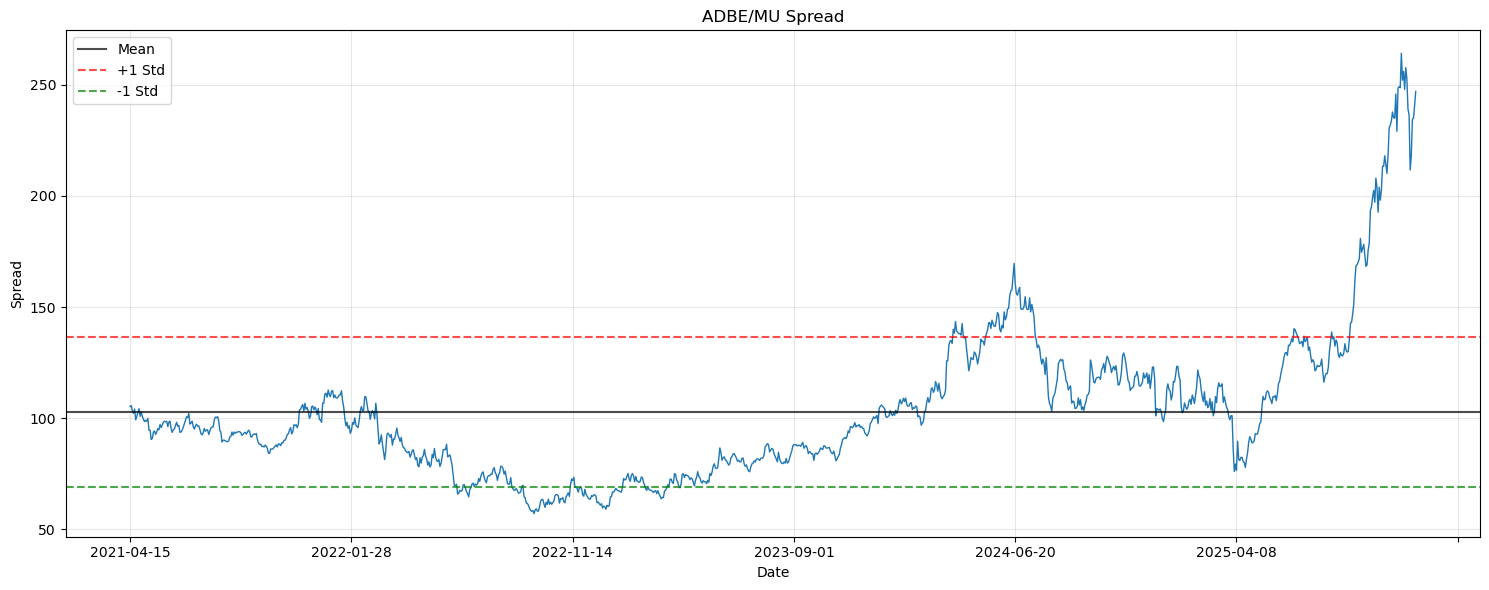

In [54]:
# Plot spread for ADBE/MU
plt.figure(figsize=(15, 6))
spread_pair1.plot(title='ADBE/MU Spread', linewidth=1)
plt.axhline(spread_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(spread_pair1.mean() + spread_pair1.std(), color='red', linestyle='--', alpha=0.7, label='+1 Std')
plt.axhline(spread_pair1.mean() - spread_pair1.std(), color='green', linestyle='--', alpha=0.7, label='-1 Std')
plt.ylabel('Spread')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

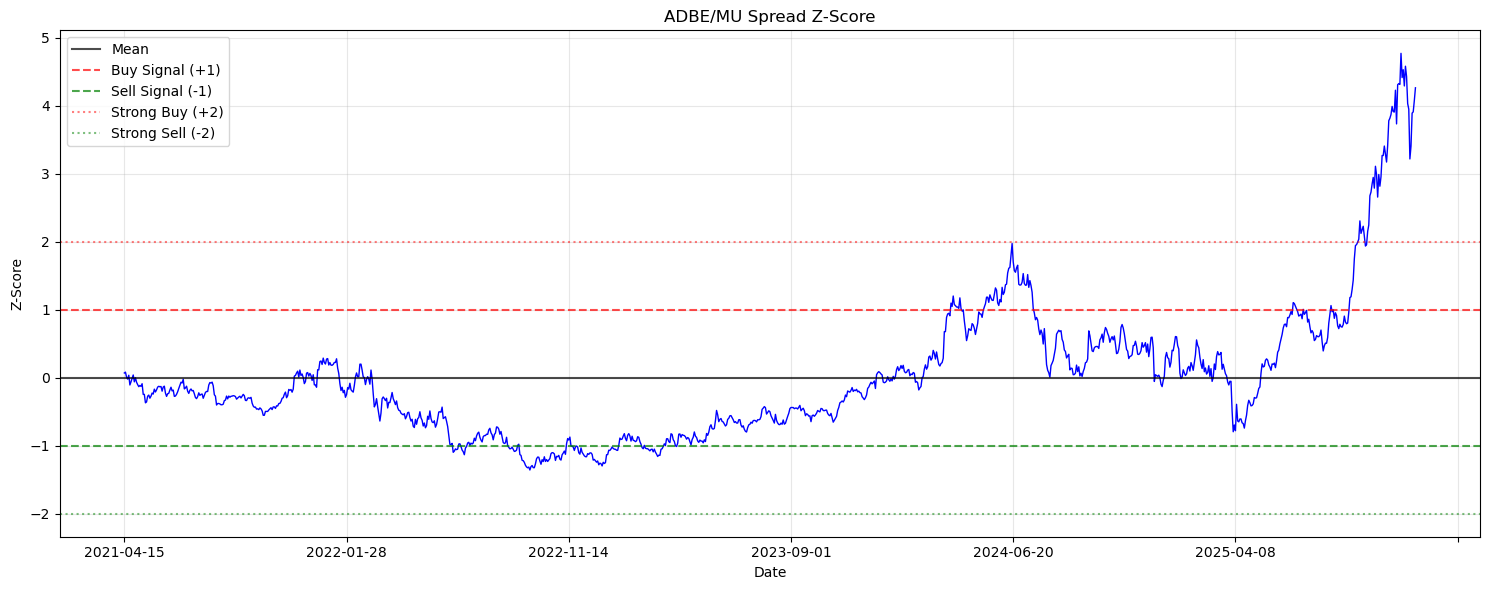

Z-score statistics for ADBE/MU:
Mean: -0.0000
Std: 1.0004
Min: -1.3569
Max: 4.7720


In [55]:
# Z-score calculation and visualization for ADBE/CADJPY
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Calculate z-score of spread
zscore_pair1 = zscore(spread_pair1)

# Plot z-score
plt.figure(figsize=(15, 6))
zscore_pair1.plot(title='ADBE/MU Spread Z-Score', linewidth=1, color='blue')
plt.axhline(zscore_pair1.mean(), color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Buy Signal (+1)')
plt.axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Sell Signal (-1)')
plt.axhline(2.0, color='red', linestyle=':', alpha=0.5, label='Strong Buy (+2)')
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5, label='Strong Sell (-2)')
plt.ylabel('Z-Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Z-score statistics for ADBE/MU:")
print(f"Mean: {zscore_pair1.mean():.4f}")
print(f"Std: {zscore_pair1.std():.4f}")
print(f"Min: {zscore_pair1.min():.4f}")
print(f"Max: {zscore_pair1.max():.4f}")

In [56]:
# Trading Strategy for ADBE/MU
# Create DataFrame with signal and position

trades_pair1 = pd.DataFrame({
    'signal': zscore_pair1,
    'position': spread_pair1,
    'ADBE': S1,
    'MU': S2
})

# Add trading side based on z-score thresholds
trades_pair1['side'] = 0.0
trades_pair1.loc[trades_pair1.signal <= -1, 'side'] = 1.0   # Long spread when z-score <= -1
trades_pair1.loc[trades_pair1.signal >= 1, 'side'] = -1.0   # Short spread when z-score >= 1

# Calculate position changes and returns
trades_pair1['position_change'] = trades_pair1.position.pct_change()
trades_pair1['strategy_returns'] = trades_pair1.position_change * trades_pair1.side.shift(1)

# Remove NaN values
trades_pair1 = trades_pair1.dropna()

print("ADBE/MU Trading Signals Summary:")
print(f"Total trading signals: {(trades_pair1.side != 0).sum()}")
print(f"Long signals: {(trades_pair1.side == 1).sum()}")
print(f"Short signals: {(trades_pair1.side == -1).sum()}")
print(f"Signal ratio: {(trades_pair1.side != 0).mean():.2%}")

# Display first few trades
print("\nFirst 10 trading signals:")
signal_trades = trades_pair1[trades_pair1.side != 0].head(10)
print(signal_trades[['signal', 'side', 'strategy_returns']])

ADBE/MU Trading Signals Summary:
Total trading signals: 247
Long signals: 126
Short signals: 121
Signal ratio: 21.26%

First 10 trading signals:
              signal  side  strategy_returns
Date                                        
2022-06-16 -1.096400   1.0         -0.000000
2022-06-17 -1.079092   1.0          0.008877
2022-06-21 -1.046499   1.0          0.016570
2022-06-22 -1.057575   1.0         -0.005539
2022-06-23 -1.050092   1.0          0.003763
2022-06-28 -1.013189   1.0         -0.000000
2022-06-29 -1.063785   1.0         -0.024888
2022-06-30 -1.087618   1.0         -0.012023
2022-07-01 -1.132557   1.0         -0.022946
2022-07-05 -1.035443   1.0          0.050751


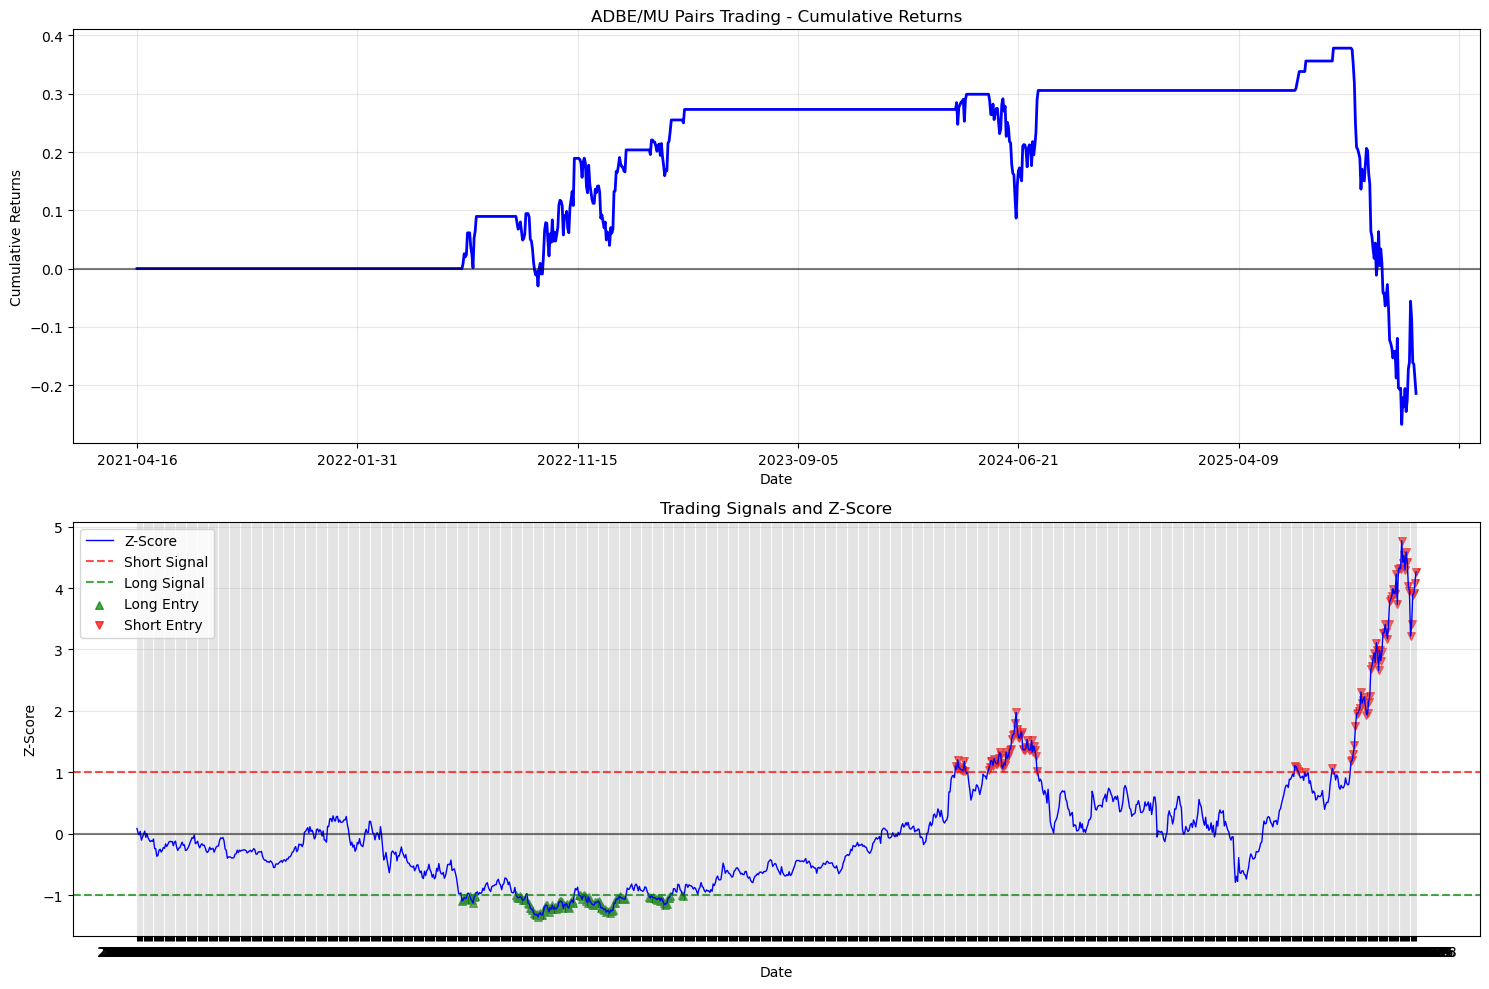


ADBE/MU Strategy Performance:
Total Return: -0.2144 (-21.44%)
Annualized Sharpe Ratio: -0.2283
Maximum Drawdown: -0.6457 (-64.57%)


In [57]:
# Plot strategy performance for ADBE/MU
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot cumulative returns
cumulative_returns_pair1 = trades_pair1.strategy_returns.cumsum()
cumulative_returns_pair1.plot(ax=axes[0], title='ADBE/MU Pairs Trading - Cumulative Returns', 
                              linewidth=2, color='blue')
axes[0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0].set_ylabel('Cumulative Returns')
axes[0].grid(True, alpha=0.3)

# Plot signals with z-score
axes[1].plot(trades_pair1.index, trades_pair1.signal, linewidth=1, color='blue', label='Z-Score')
axes[1].axhline(1.0, color='red', linestyle='--', alpha=0.7, label='Short Signal')
axes[1].axhline(-1.0, color='green', linestyle='--', alpha=0.7, label='Long Signal')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.5)

# Mark actual trades
long_trades = trades_pair1[trades_pair1.side == 1]
short_trades = trades_pair1[trades_pair1.side == -1]
axes[1].scatter(long_trades.index, long_trades.signal, color='green', marker='^', s=30, alpha=0.7, label='Long Entry')
axes[1].scatter(short_trades.index, short_trades.signal, color='red', marker='v', s=30, alpha=0.7, label='Short Entry')

axes[1].set_title('Trading Signals and Z-Score')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics
total_return = cumulative_returns_pair1.iloc[-1]
sharpe_ratio = trades_pair1.strategy_returns.mean() / trades_pair1.strategy_returns.std() * np.sqrt(252)
max_drawdown = (cumulative_returns_pair1 - cumulative_returns_pair1.expanding().max()).min()

print(f"\nADBE/MU Strategy Performance:")
print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")